# Assignment 3 — Online Shoppers Purchasing Intention (Problem Type 1)

**Dataset:** Online Shoppers Purchasing Intention (UCI)

- Task 1: Retrieve & prepare data (cleaning + validation only)
- Task 2: Feature engineering (transformations + feature selection analysis)
- Task 3: Data modeling (≥2 classification models, ≥2 clustering models, + clustered-data supervised model, + innovative model)


## Setup

In [2]:
import pandas as pd
import numpy as np

df_raw = pd.read_csv("online_shoppers_intention.csv")
df = df_raw.copy(deep=True) # we only modify df

## <u>Task 1 — Retrieving & Preparing the Data (Pre-processing only)</u>
### Project Goal

- **Classification goal:** Predict whether a user session results in a purchase (**Revenue**).
- **Clustering goal:** Segment sessions into behavior-based clusters (e.g., browsing patterns), later used as an additional feature for supervised prediction.


### __1.1 - Schema and basic quality checks__

In [3]:
# Quick overview
print("Shape :", df.shape)
print("Types : ", df.dtypes)
display(df.head(3))


Shape : (12330, 18)
Types :  Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False


In [4]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


### 1.2 - Column-by-column validity checks, duplicates, month canonicalization

Based on the dataset information and variables table that we can find here (https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset), we ensure every column has valid types and data with a data contract.

In [5]:
DATA_CONTRACT = {
    # counts (should be integers >= 0)
    "Administrative": {"type": "int", "min": 0},
    "Informational": {"type": "int", "min": 0},
    "ProductRelated": {"type": "int", "min": 0},

    # durations (floats >= 0)
    "Administrative_Duration": {"type": "float", "min": 0.0},
    "Informational_Duration": {"type": "float", "min": 0.0},
    "ProductRelated_Duration": {"type": "float", "min": 0.0},

    # rates/ratios (floats in [0,1])
    "BounceRates": {"type": "float", "min": 0.0, "max": 1.0},
    "ExitRates": {"type": "float", "min": 0.0, "max": 1.0},
    "SpecialDay": {"type": "float", "min": 0.0, "max": 1.0},

    # values (non-negative)
    "PageValues": {"type": "float", "min": 0.0},

    # encoded categorical as integers (>=1 in this dataset)
    "OperatingSystems": {"type": "int", "min": 1},
    "Browser": {"type": "int", "min": 1},
    "Region": {"type": "int", "min": 1},
    "TrafficType": {"type": "int", "min": 1},

    # true categorical
    "Month": {"type": "str"},
    "VisitorType": {"type": "str"},

    # boolean
    "Weekend": {"type": "bool"},
    "Revenue": {"type": "bool"},
}


In [6]:
# SIMPLE STRUCTURAL CHECKS

# columns: any missing or extra?
expected_cols = set(DATA_CONTRACT.keys())
actual_cols = set(df.columns)

print("Missing columns:", expected_cols - actual_cols)
print("Unexpected columns:", actual_cols - expected_cols)

# missing values
missing = df.isna().sum()
print("\nMissing values (non-zero only):")
print(missing[missing > 0])

# 3.3 duplicates
dup_count = df.duplicated().sum()
print("\nExact duplicate rows:", dup_count)


Missing columns: set()
Unexpected columns: set()

Missing values (non-zero only):
Series([], dtype: int64)

Exact duplicate rows: 125


In [7]:
# Strip whitespace on object columns
obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
for c in obj_cols:
    df[c] = df[c].astype("string").str.strip().str.replace(r"\s+", " ", regex=True)

# Month canonicalization (only if Month is string/object)
if pd.api.types.is_string_dtype(df["Month"]) or df["Month"].dtype == object:
    df["Month"] = df["Month"].replace({"June": "Jun", "JUNE": "Jun", "june": "Jun"})
    print("Month unique values (after canonicalization):")
    print(sorted(df["Month"].dropna().unique().tolist()))
else:
    print("Month is not string dtype (dtype =", df["Month"].dtype, "). Leaving as-is in Task 1.")


# canonicalize spelling
df["Month"] = df["Month"].replace({"June": "Jun"})

print("Month dtype:", df["Month"].dtype)
print("Month unique values:", sorted(df["Month"].dropna().unique().tolist()))
print("Month missing:", df["Month"].isna().sum())


Month unique values (after canonicalization):
['Aug', 'Dec', 'Feb', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep']
Month dtype: string
Month unique values: ['Aug', 'Dec', 'Feb', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep']
Month missing: 0


In [8]:
# drop duplicates
before = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
after = df.shape[0]
print(f"Removed {before-after} duplicate rows. New shape: {df.shape}")


Removed 125 duplicate rows. New shape: (12205, 18)


In [9]:
# column by column validity check using the data contract
def contract_check(df, contract):
    issues = []
    for col, rules in contract.items():
        s = df[col]
        # missing
        miss = int(s.isna().sum())
        if miss > 0:
            issues.append((col, "missing_values", miss))

        # type checks (soft checks; pandas dtypes vary)
        if rules["type"] in ("int", "float"):
            if not pd.api.types.is_numeric_dtype(s):
                issues.append((col, "non_numeric_dtype", str(s.dtype)))
                continue
            # min/max
            if "min" in rules:
                bad = int((s < rules["min"]).sum())
                if bad > 0:
                    issues.append((col, f"below_min_{rules['min']}", bad))
            if "max" in rules:
                bad = int((s > rules["max"]).sum())
                if bad > 0:
                    issues.append((col, f"above_max_{rules['max']}", bad))

        if rules["type"] == "bool":
            if s.dtype != bool:
                issues.append((col, "not_bool_dtype", str(s.dtype)))

        if rules["type"] == "str":
            if s.dtype != object:
                issues.append((col, "not_object_dtype", str(s.dtype)))

    return issues

issues = contract_check(df, DATA_CONTRACT)
issues[:20], len(issues)


([('Month', 'not_object_dtype', 'string'),
  ('VisitorType', 'not_object_dtype', 'string')],
 2)

In [10]:
# cross field consistency checks, if count == 0, duration should be 0
pairs = [
   ("Administrative", "Administrative_Duration"),
("Informational", "Informational_Duration"),
("ProductRelated", "ProductRelated_Duration")
]

for count_col, dur_col in pairs:
    dur_when_count0 = int(((df[count_col] == 0) & (df[dur_col] > 0)).sum())
    count_when_dur0 = int(((df[count_col] > 0) & (df[dur_col] == 0)).sum())

    print(f"{count_col} vs {dur_col}")
    print("  duration>0 when count==0:", dur_when_count0)
    print("  count>0 when duration==0:", count_when_dur0)


Administrative vs Administrative_Duration
  duration>0 when count==0: 0
  count>0 when duration==0: 135
Informational vs Informational_Duration
  duration>0 when count==0: 0
  count>0 when duration==0: 226
ProductRelated vs ProductRelated_Duration
  duration>0 when count==0: 0
  count>0 when duration==0: 592


### 1.3 - Outliers identification

In [11]:
outlier_cols = [
    "Administrative_Duration",
    "Informational_Duration",
    "ProductRelated_Duration",
    "BounceRates",
    "ExitRates",
    "PageValues",
    "SpecialDay"
]


In [12]:
df[outlier_cols].describe(percentiles=[0.01, 0.05, 0.95, 0.99]).T


,count,mean,std,min,1%,5%,50%,95%,99%,max
Administrative_Duration,12205.0,81.646331,177.491845,0.0,0.00000,0.000000,9.000000,352.208095,838.704889,3398.750000
Informational_Duration,12205.0,34.825454,141.424807,0.0,0.00000,0.000000,0.000000,199.000000,722.379200,2549.375000
ProductRelated_Duration,12205.0,1206.982457,1919.601400,0.0,0.00000,0.000000,608.942857,4312.956282,8704.271573,63973.522230
BounceRates,12205.0,0.020370,0.045255,0.0,0.00000,0.000000,0.002899,0.149333,0.200000,0.200000
ExitRates,12205.0,0.041466,0.046163,0.0,0.00125,0.004545,0.025000,0.173714,0.200000,0.200000
PageValues,12205.0,5.949574,18.653671,0.0,0.00000,0.000000,0.000000,38.301457,86.108689,361.763742
SpecialDay,12205.0,0.061942,0.199666,0.0,0.00000,0.000000,0.000000,0.600000,1.000000,1.000000


In [13]:
outlier_summary = {}

for col in outlier_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    outlier_summary[col] = {
        "outlier_count": int(((df[col] < lower) | (df[col] > upper)).sum()),
        "outlier_pct": float(((df[col] < lower) | (df[col] > upper)).mean() * 100),
        "max_value": float(df[col].max())
    }

pd.DataFrame(outlier_summary).T


,outlier_count,outlier_pct,max_value
Administrative_Duration,1149.0,9.414175,3398.750000
Informational_Duration,2405.0,19.705039,2549.375000
ProductRelated_Duration,951.0,7.791889,63973.522230
BounceRates,1428.0,11.700123,0.200000
ExitRates,1325.0,10.856206,0.200000
PageValues,2730.0,22.367882,361.763742
SpecialDay,1249.0,10.233511,1.000000


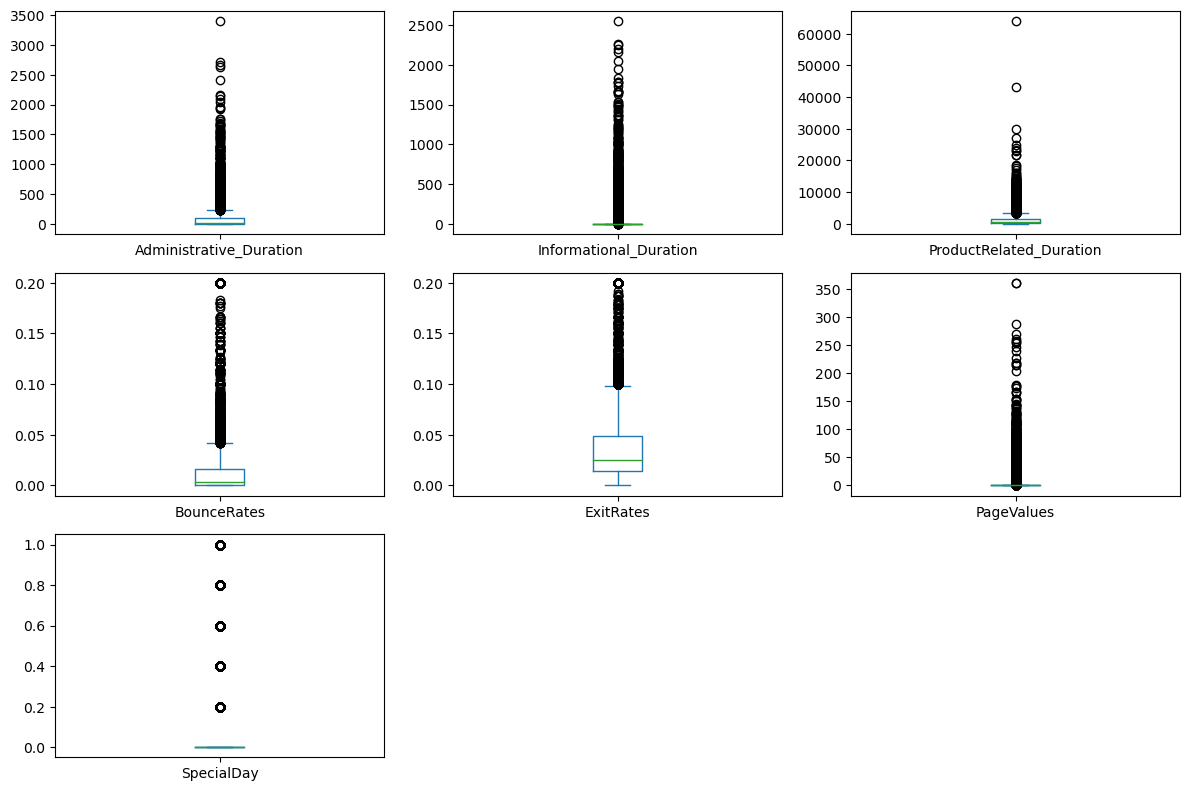

In [14]:
import matplotlib.pyplot as plt

df[outlier_cols].plot(kind="box", subplots=True, layout=(3,3), figsize=(12,8))
plt.tight_layout()


We conducted exploratory outlier detection on continuous variables using summary statistics and IQR-based diagnostics. Several attributes (e.g. ProductRelated_Duration and PageValues) exhibited heavy-tailed distributions with extreme values. As these values reflect genuine user behavior rather than data errors, no outliers were removed at this stage. Their influence was considered in subsequent feature engineering and modeling steps.

At this stage, no feature transformation, scaling, encoding, or modeling has been performed.
These steps are introduced in Task 2 to ensure consistency across training, validation, and test sets.

## <u>Task 2 — Feature Engineering (transformations + feature selection)</u>
We now define consistent preprocessing for **classification** and **clustering** using sklearn Pipelines.

Principles:
- Keep preprocessing inside a Pipeline/ColumnTransformer to ensure consistency across splits.
- Perform feature selection based on training data only.


### __2.1 - Train / Validation / Test split__
The dataset was split into training (70%), validation (15%), and test (15%) sets using stratified sampling to preserve the class distribution of the target variable. This ensured unbiased model evaluation and prevented information leakage during feature engineering and model selection.

In [15]:
from sklearn.model_selection import train_test_split

TARGET = "Revenue"
RANDOM_STATE = 42

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=RANDOM_STATE
)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)


Train: (8543, 17)
Val:   (1831, 17)
Test:  (1831, 17)


### __2.2 - Feature grouping__
Different features need different transformations. Treating everything the same hurts performance and interpretability.

In [16]:
# Count features (zero-inflated, integer)
count_features = [
    "Administrative", "Informational", "ProductRelated"
]

# Duration & value features (heavy-tailed)
duration_features = [
    "Administrative_Duration", "Informational_Duration",
    "ProductRelated_Duration", "PageValues"
]

# Rate / bounded features
rate_features = [
    "BounceRates", "ExitRates", "SpecialDay"
]

# Encoded categoricals (already numeric labels, NOT ordinal)
encoded_cat_features = [
    "OperatingSystems", "Browser", "Region", "TrafficType"
]

# True categoricals
categorical_features = [
    "Month", "VisitorType"
]

# Binary
binary_features = ["Weekend"]


### __2.3 - Feature transformation choices / Preprocessing pipelines__

#### 2.3.1 Log-transform heavy-tailed features

Durations and PageValues have extreme outliers. Log transform:
- stabilizes variance
- reduces dominance of extreme values
- helps linear & distance-based models

We use log1p to handle zeros safely.

#### 2.3.2 Scaling

Required for clustering (distance-based)

Optional but helpful for classification models

We use StandardScaler.

#### 2.3.3 Encoding categoricals

Month, VisitorType → OneHotEncoder

Encoded numeric categories (Browser, Region, etc.) → treat as categorical, not ordinal → OneHotEncoder

Why not leave them numeric?
Their numeric labels have no order meaning. Leaving them numeric introduces fake ordinal relationships.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
import numpy as np

log_transformer = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

numeric_pipeline = Pipeline(steps=[
    ("log", log_transformer),
    ("scaler", StandardScaler())
])

rate_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))
])

preprocess_classification = ColumnTransformer(
    transformers=[
        ("counts", numeric_pipeline, count_features),
        ("durations", numeric_pipeline, duration_features),
        ("rates", rate_pipeline, rate_features),
        ("encoded_cat", categorical_pipeline, encoded_cat_features),
        ("categorical", categorical_pipeline, categorical_features),
        ("binary", "passthrough", binary_features),
    ],
    remainder="drop"
)

### __2.4 - Clustering preprocessing pipeline__

Differences from classification:

- No target
- Scaling is mandatory
- Same transformations → consistency

In [18]:
preprocess_clustering = ColumnTransformer(
    transformers=[
        ("counts", numeric_pipeline, count_features),
        ("durations", numeric_pipeline, duration_features),
        ("rates", rate_pipeline, rate_features),
        ("encoded_cat", categorical_pipeline, encoded_cat_features),
        ("categorical", categorical_pipeline, categorical_features),
        ("binary", "passthrough", binary_features),
    ],
    remainder="drop"
)

#### __2.5 - Correlation with target (classification)__

What you should observe:

- PageValues (log) → strong positive correlation
- Duration-related features → moderate
- BounceRates / ExitRates → negative

In [19]:
X_train_processed = preprocess_classification.fit_transform(X_train)
feature_names = preprocess_classification.get_feature_names_out()

X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
corr_with_target = X_train_df.corrwith(y_train).sort_values(key=np.abs, ascending=False)

corr_with_target.head(15)


c:\Users\froze\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\froze\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


encoded_cat__TrafficType_2           -0.039253
encoded_cat__TrafficType_15           0.038728
counts__Administrative               -0.033015
encoded_cat__TrafficType_3            0.032976
encoded_cat__Region_1                 0.031770
counts__ProductRelated               -0.031317
durations__Administrative_Duration   -0.029754
encoded_cat__Region_5                -0.027820
encoded_cat__TrafficType_10           0.027602
durations__ProductRelated_Duration   -0.026999
rates__ExitRates                      0.023563
encoded_cat__Browser_13              -0.022844
encoded_cat__TrafficType_9            0.022757
encoded_cat__Browser_12               0.022341
encoded_cat__Browser_2                0.020796
dtype: float64

### __2.6 - Redundancy check__


In [23]:
corr_matrix = X_train_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = [
    (col, upper[col].idxmax(), upper[col].max())
    for col in upper.columns if upper[col].max() > 0.9
]

high_corr_pairs[:10]


[('durations__Administrative_Duration',
  'counts__Administrative',
  0.926201207539248),
 ('durations__Informational_Duration',
  'counts__Informational',
  0.916202442575112),
 ('encoded_cat__Browser_11', 'encoded_cat__OperatingSystems_5', 1.0),
 ('categorical__VisitorType_Returning_Visitor',
  'categorical__VisitorType_New_Visitor',
  0.9707061326291561)]

__Decision rationale:__
- No features removed yet
- Strong predictors retained (PageValues, durations)
- Redundancy will be handled by:
- regularization (classification)
- PCA / clustering robustness (later)

In Task 2, feature engineering was performed using sklearn pipelines to ensure consistent transformations across training, validation, and test sets. Features were grouped by semantic type and transformed accordingly. Heavy-tailed duration and value variables were log-transformed, categorical variables were one-hot encoded, and all numeric features were scaled. Feature relevance was evaluated using correlation analysis on the training set only, confirming PageValues and session duration variables as strong predictors of purchase intent. No features were removed at this stage to preserve information for downstream models.

In [20]:
df["Revenue"].value_counts()

Revenue
False    10297
True      1908
Name: count, dtype: int64

In [21]:
# Check Revenue distribution (imbalance)
print("Revenue distribution before balancing:")
print(df["Revenue"].value_counts())
print("\nPercentage distribution:")
print(df["Revenue"].value_counts(normalize=True) * 100)

Revenue distribution before balancing:
Revenue
False    10297
True      1908
Name: count, dtype: int64

Percentage distribution:
Revenue
False    84.367063
True     15.632937
Name: proportion, dtype: float64


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm',fmt=".2f", annot=True)
plt.show()

ValueError: could not convert string to float: 'Returning_Visitor'

<Figure size 1200x1000 with 0 Axes>

In [23]:
# Generate and display the correlation matrix with a gradient background
corrMatrix = df.corr()
corrMatrix.style.background_gradient(cmap='Blues')

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
Administrative,1.000000,0.600457,0.375256,0.254813,0.428305,0.371146,-0.213096,-0.311255,0.097017,-0.096951,0.094423,-0.006586,-0.025622,-0.007262,-0.034643,0.029424,0.023825,0.136330
Administrative_Duration,0.600457,1.000000,0.301419,0.237211,0.286863,0.353583,-0.136913,-0.201971,0.066228,-0.074666,0.056250,-0.007529,-0.015742,-0.006729,-0.014991,0.024208,0.013259,0.091768
Informational,0.375256,0.301419,1.000000,0.618648,0.372572,0.386052,-0.109095,-0.159429,0.047406,-0.049350,0.062173,-0.009721,-0.038787,-0.030317,-0.035197,-0.048505,0.034359,0.093626
Informational_Duration,0.254813,0.237211,0.618648,1.000000,0.279082,0.346596,-0.069878,-0.102852,0.030090,-0.031261,0.043552,-0.009734,-0.019573,-0.027891,-0.025126,-0.039760,0.023193,0.069358
ProductRelated,0.428305,0.286863,0.372572,0.279082,1.000000,0.860330,-0.192884,-0.286082,0.054201,-0.025839,0.154323,0.004194,-0.013586,-0.040108,-0.044223,-0.113693,0.013477,0.156042
ProductRelated_Duration,0.371146,0.353583,0.386052,0.346596,0.860330,1.000000,-0.173829,-0.245265,0.050923,-0.038122,0.135882,0.002870,-0.007724,-0.034869,-0.037390,-0.109336,0.004903,0.150077
BounceRates,-0.213096,-0.136913,-0.109095,-0.069878,-0.192884,-0.173829,1.000000,0.902144,-0.115799,0.088626,-0.054076,0.026811,-0.015501,0.002787,0.089184,-0.134669,-0.034808,-0.145091
ExitRates,-0.311255,-0.201971,-0.159429,-0.102852,-0.286082,-0.245265,0.902144,1.000000,-0.173627,0.117176,-0.086049,0.016345,-0.003323,-0.000987,0.087478,-0.181618,-0.053061,-0.204320
PageValues,0.097017,0.066228,0.047406,0.030090,0.054201,0.050923,-0.115799,-0.173627,1.000000,-0.064481,0.066244,0.018632,0.045908,0.010588,0.012286,0.087338,0.010801,0.491894
SpecialDay,-0.096951,-0.074666,-0.049350,-0.031261,-0.025839,-0.038122,0.088626,0.117176,-0.064481,1.000000,-0.259992,0.012806,0.003528,-0.016450,0.052856,-0.075330,-0.017723,-0.083601


For Revenue the features are going to be "PageValue", "ExitRate","BounceRate", "ProductRelated", "ProductRelated_Duration", "Administrative", "Month", "VisitorType"

For ExitRate the features are going to be "Revenue","VisitorType", "PageValue", "ProductRelated_Duration", "ProductRelated", "BounceRate", "Administrative","Administrative_Duration", "Informational".

For VisitorType the features are going to be "ExitRate","BounceRate", "ProductRelated", "ProductRelated_Duration", "Revenue", "OperatingSystem"

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_and_save(model, X_train, y_train, X_test, y_test, model_name, results_dict):
    model.fit(X_train, y_train)

    print('Model accuracy for train set: {0:.3f}'.format(model.score(X_train, y_train)))
    print('Model accuracy for test set: {0:.3f}'.format(model.score(X_test, y_test)))
    
    y_pred = model.predict(X_test)

    # Classification Report
    print('\n{}'.format(classification_report(y_test, y_pred)))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n', cm)

    # Accuracy Score
    auc = accuracy_score(y_test, y_pred)
    print('\nAccuracy Score: ', round(auc,3))
    
    # Collect metrics
    results_dict[model_name] = {
        'Train Accuracy': model.score(X_train, y_train),
        'Test Accuracy': model.score(X_test, y_test),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1': f1_score(y_test, y_pred, average='weighted')
    }
    
    return model, results_dict

In [25]:
def train_and_save_hyper(model, X_train, y_train, X_test, y_test, model_name, results_dict):
    model.fit(X_train, y_train)

    print('Model accuracy for train set: {0:.3f}'.format(model.score(X_train, y_train)))
    print('Model accuracy for test set: {0:.3f}'.format(model.score(X_test, y_test)))

    print("Best parameters found: ", model.best_params_)
    print("Best cross-validation score: ", model.best_score_)
    
    y_pred = model.predict(X_test)

    # Classification Report
    print('\n{}'.format(classification_report(y_test, y_pred)))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n', cm)

    # Accuracy Score
    auc = accuracy_score(y_test, y_pred)
    print('\nAccuracy Score: ', round(auc,3))
    
    # Collect metrics
    results_dict[model_name] = {
        'Train Accuracy': model.score(X_train, y_train),
        'Test Accuracy': model.score(X_test, y_test),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1': f1_score(y_test, y_pred, average='weighted')
    }
    
    return model, results_dict

Classification

In [26]:
# Separating dependent and independent variables
X_class = df[["PageValues", "ExitRates","BounceRates", "ProductRelated", "ProductRelated_Duration", "Administrative", "Month", "VisitorType"]]
y_class = df["Revenue"]

In [27]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing sets for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=0, shuffle=True)

In [28]:
from sklearn.preprocessing import StandardScaler
# Classification scaling
scaler = StandardScaler()

X_train_scaled_class = X_train_class.copy()
X_test_scaled_class = X_test_class.copy()

X_train_scaled_class[["PageValues", "ExitRates","BounceRates", "ProductRelated", "ProductRelated_Duration", "Administrative"]] = scaler.fit_transform(X_train_class[["PageValues", "ExitRates","BounceRates", "ProductRelated", "ProductRelated_Duration", "Administrative"]])
X_test_scaled_class[["PageValues", "ExitRates","BounceRates", "ProductRelated", "ProductRelated_Duration", "Administrative"]] = scaler.transform(X_test_class[["PageValues", "ExitRates","BounceRates", "ProductRelated", "ProductRelated_Duration", "Administrative"]])

results_class = {}

Logistic Regression

In [29]:
# LR model without hyperparameter tuning
LR = LogisticRegression()
model_LogR, results_class = train_and_save(LR, X_train_scaled_class, y_train_class, X_test_scaled_class, y_test_class, "Logistic Regression", results_class)

Model accuracy for train set: 0.881
Model accuracy for test set: 0.884

              precision    recall  f1-score   support

       False       0.89      0.98      0.93      2063
        True       0.77      0.35      0.49       378

    accuracy                           0.88      2441
   macro avg       0.83      0.67      0.71      2441
weighted avg       0.87      0.88      0.86      2441


Confusion Matrix:
 [[2023   40]
 [ 244  134]]

Accuracy Score:  0.884


In [30]:
# Logistic Regression with hyperparameter tuning
params_log = {
    'C': [0.001, 0.01, 0.1, 1, 5],
    'solver': ['lbfgs'],
    'max_iter': [100,200,500]
}
skf = StratifiedKFold(n_splits = 10)
LR_hyper = GridSearchCV(LR, param_grid = params_log, n_jobs =-1, cv = skf)
model_LogR_hyper, results_class = train_and_save_hyper(LR_hyper, X_train_scaled_class, y_train_class, X_test_scaled_class, y_test_class, "Logistic Regression Tuned", results_class)

Model accuracy for train set: 0.881
Model accuracy for test set: 0.884
Best parameters found:  {'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}
Best cross-validation score:  0.8810937421346712

              precision    recall  f1-score   support

       False       0.89      0.98      0.93      2063
        True       0.77      0.35      0.49       378

    accuracy                           0.88      2441
   macro avg       0.83      0.67      0.71      2441
weighted avg       0.87      0.88      0.86      2441


Confusion Matrix:
 [[2023   40]
 [ 244  134]]

Accuracy Score:  0.884


Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state=0)
model_RF, results_class = train_and_save(RF, X_train_scaled_class, y_train_class, X_test_scaled_class, y_test_class, "Random Forest", results_class)

Model accuracy for train set: 1.000
Model accuracy for test set: 0.902

              precision    recall  f1-score   support

       False       0.92      0.97      0.94      2063
        True       0.77      0.53      0.63       378

    accuracy                           0.90      2441
   macro avg       0.84      0.75      0.79      2441
weighted avg       0.90      0.90      0.90      2441


Confusion Matrix:
 [[2001   62]
 [ 176  202]]

Accuracy Score:  0.902


In [32]:
# Random Forest with hyperparameter tuning
from sklearn.model_selection import GridSearchCV, StratifiedKFold

params_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
skf = StratifiedKFold(n_splits=10)
RF_hyper = GridSearchCV(RandomForestClassifier(random_state=0), param_grid=params_rf, n_jobs=-1, cv=skf)
model_RF_hyper, results_class = train_and_save_hyper(
    RF_hyper, X_train_scaled_class, y_train_class, X_test_scaled_class, y_test_class, "Random Forest Tuned", results_class
)

KeyboardInterrupt: 

Clustering

In [232]:
# K-Means Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering (example: all continuous columns)
clustering_features = df.drop("Revenue", axis=1)

# Standardize features
scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(clustering_features)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans_labels = kmeans.fit_predict(X_cluster)
df['KMeans_Cluster'] = kmeans_labels

c:\Users\froze\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
# DBSCAN Clustering
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_cluster)
df['DBSCAN_Cluster'] = dbscan_labels

# Show cluster label counts
print('KMeans cluster counts:')
print(df['KMeans_Cluster'].value_counts())
print('\nDBSCAN cluster counts:')
print(df['DBSCAN_Cluster'].value_counts())

KMeans cluster counts:
KMeans_Cluster
1    9632
0    1626
2     947
Name: count, dtype: int64

DBSCAN cluster counts:
DBSCAN_Cluster
 0     6287
-1     2941
 1     1488
 3      882
 4      303
 2       77
 5       45
 15      29
 21      27
 24      11
 20      10
 7       10
 6        9
 18       9
 19       8
 17       8
 23       8
 10       8
 22       7
 8        6
 16       5
 9        5
 11       5
 12       5
 25       5
 13       4
 14       3
Name: count, dtype: int64


In [ ]:
from sklearn.metrics import silhouette_score

# Silhouette score for K-Means
kmeans_silhouette = silhouette_score(X_cluster, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette:.3f}")

# Silhouette score for DBSCAN (ignore noise points)
dbscan_mask = dbscan_labels != -1
if dbscan_mask.sum() > 1 and len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(X_cluster[dbscan_mask], dbscan_labels[dbscan_mask])
    print(f"DBSCAN Silhouette Score (excluding noise): {dbscan_silhouette:.3f}")
else:
    print("DBSCAN did not form enough clusters for silhouette score.")

K-Means Silhouette Score: 0.255
DBSCAN Silhouette Score (excluding noise): 0.015
